In [1]:
!pip install -r requirements.txt

import os
import sys
import json
import argparse

# --- 1. Setup and Parameter Definition ---

# Ensure the src directory is in the Python path
# This is crucial if you're running the script from the repository root.
if os.path.abspath('src') not in sys.path:
    sys.path.insert(0, os.path.abspath('src'))

# Import your project-specific modules
try:
    from src.synqronix.config import define_parameters
    from src.synqronix.main import main, build_data
except ImportError as e:
    print(f"Error importing synqronix modules: {e}")
    print("Please ensure 'src/synqronix/config.py' and 'src/synqronix/main.py' exist and are accessible.")
    sys.exit(1)

print("Modules loaded successfully.")

Modules loaded successfully.


In [ ]:
# --- Define Parameters ---
# These values serve as defaults if not overridden by environment variables.
# For qBraid Lab, you could potentially set these as environment variables
# in your qBraid Lab environment settings if you prefer, or pass them
# as part of a custom startup script if qBraid supports that.

NB_DATA_DIR = os.environ.get("NB_DATA_DIR", "./data/Auditory cortex data")
NB_SAVE_DIR = os.environ.get("NB_SAVE_DIR", "checkpoints/")
NB_NUM_EPOCHS = int(os.environ.get("NB_NUM_EPOCHS", "50"))
NB_QUANTUM_DEVICE = os.environ.get("NB_QUANTUM_DEVICE", "default") 

# The original workflow uses QBRAID_RUN_INPUTS, let's keep that as a fallback/override mechanism
qbraid_run_inputs_str = os.environ.get("QBRAID_RUN_INPUTS", "{}")
try:
    qbraid_run_inputs = json.loads(qbraid_run_inputs_str)
except json.JSONDecodeError:
    print(f"Warning: Could not parse QBRAID_RUN_INPUTS: {qbraid_run_inputs_str}. Using defaults.")
    qbraid_run_inputs = {}

# --- Create an argparse.Namespace object to mimic 'args' ---
# We'll use the define_parameters to get a base parser, then populate args
parser = define_parameters()
args = parser.parse_args([])

# Create an empty namespace to hold our arguments
args = argparse.Namespace()

# Populate with defaults from define_parameters first
# This ensures all expected arguments are present, even if not explicitly defined above.
default_args, _ = parser.parse_known_args([])
for arg_name in vars(default_args):
    setattr(args, arg_name, getattr(default_args, arg_name))

# Override with script-specific parameters (NB_ prefix)
args.data_dir = NB_DATA_DIR
args.save_dir = NB_SAVE_DIR
args.num_epochs = NB_NUM_EPOCHS
args.quantum_device = NB_QUANTUM_DEVICE

# Override with any QBRAID_RUN_INPUTS (highest precedence)
for k, v in qbraid_run_inputs.items():
    # Convert types if necessary, argparse usually handles this. Here we assume string for simplicity
    if k == "num_epochs":
        setattr(args, k, int(v))
    elif k == "hidden_dim": # Assuming hidden_dim might be passed from GH Actions
        setattr(args, k, int(v))
    else:
        setattr(args, k, v)


# Ensure api_key is handled. It's not in workflow_dispatch inputs, but needed for QGNN.
# It should come from the environment where the notebook is run (e.g., qBraid Lab environment variables)
args.api_key = os.environ.get("QBRAID_API_KEY", "x6fixsgqtckrp1c10shd6oiprsi8yr")
args.dataset = os.environ.get("DATASET", "anatomical")
args.add_hyperedges = os.environ.get("ADD_HYPEREDGES", "False").lower() in ['true', '1', 'yes']
print("--- Final Arguments for Pipeline --- ")

for arg_name, arg_value in vars(args).items():
    if arg_name == 'api_key' and arg_value is not None: # Don't print the actual key
        print(f"  {arg_name}: {'****' * 5}")
    else:
        print(f"  {arg_name}: {arg_value}")
print("------------------------------------ ")

--- Final Arguments for Pipeline --- 
  data_dir: /Users/mariayuffa/Downloads/Auditory cortex data
  save_dir: checkpoints/
  model_type: QGCN
  hidden_dim: 64
  num_layers: 3
  dropout_rate: 0.5
  lr: 0.001
  weight_decay: 0.0001
  batch_size: 32
  num_epochs: 50
  k: 20
  connectivity_threshold: 0.5
  add_hyperedges: False
  checkpoint_freq: 5
  resume_from: None
  evaluate_only: None
  seed: 42
  col_width: 50
  col_height: 30
  dataset: anatomical
  quantum_device: default
  shots: None
  api_key: ********************
  q_depths: [2, 2]
------------------------------------ 


In [3]:
# --- Main Training Pipeline ---
# --- 1. Build Data Loaders and Environment ---
print("\nBuilding data and environment...")
(data_loader, train_loader, val_loader,
test_loader, device, checkpoint_dir, eval_dir) = build_data(args)

print("Data and environment built successfully.")
print(f"Device: {device}")
print(f"Checkpoint Directory: {checkpoint_dir}")
print(f"Evaluation Directory: {eval_dir}")


Building data and environment...
Using device: cpu
Loading and processing data...
Found 9 session files
Processing allPlanesVariables27-Feb-2021.mat
Created 931 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 530 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 605 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 1447 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 1183 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 1180 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 459 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Skipping /Users/mariayuffa/Downloads/Auditory cortex data/031120_352ll_100um20st_FRA_diffxy/allPlanesVariables27-Feb-2021.mat because it has dubious values 🤨
Processing allPlanesVariables27-Feb-2021.mat
Created 592 subgraphs from session
Total subgraphs created: 6927
Data split: 4848 tr

/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



--- Starting Training for Model Type: GCN ---
Model created: GCN
Total parameters: 11,593
Starting training...
Starting training for 160 epochs...
Device: cpu
Model parameters: 11,593


Validation: 100%|██████████| 33/33 [00:00<00:00, 441.04it/s]


Epoch   1/160 | Train Loss: 2.1833 | Train Acc: 0.1632 | Val Loss: 2.1558 | Val Acc: 0.1795 | Val F1: 0.0547 | Time: 1.12s


Validation: 100%|██████████| 33/33 [00:00<00:00, 461.69it/s]


Epoch   2/160 | Train Loss: 2.1624 | Train Acc: 0.1804 | Val Loss: 2.1395 | Val Acc: 0.1877 | Val F1: 0.0737 | Time: 1.15s


Validation: 100%|██████████| 33/33 [00:00<00:00, 473.40it/s]


Epoch   3/160 | Train Loss: 2.1526 | Train Acc: 0.1828 | Val Loss: 2.1258 | Val Acc: 0.1928 | Val F1: 0.0957 | Time: 0.98s


Validation: 100%|██████████| 33/33 [00:00<00:00, 485.99it/s]


Epoch   4/160 | Train Loss: 2.1454 | Train Acc: 0.1838 | Val Loss: 2.1150 | Val Acc: 0.1969 | Val F1: 0.1000 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 492.68it/s]


New best model saved at epoch 4 with validation accuracy: 0.2037
Epoch   5/160 | Train Loss: 2.1378 | Train Acc: 0.1866 | Val Loss: 2.1033 | Val Acc: 0.2037 | Val F1: 0.1110 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 488.96it/s]


Epoch   6/160 | Train Loss: 2.1319 | Train Acc: 0.1914 | Val Loss: 2.1010 | Val Acc: 0.2105 | Val F1: 0.1286 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 473.49it/s]


Epoch   7/160 | Train Loss: 2.1266 | Train Acc: 0.1947 | Val Loss: 2.0935 | Val Acc: 0.2083 | Val F1: 0.1199 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 480.99it/s]


New best model saved at epoch 7 with validation accuracy: 0.2150
Epoch   8/160 | Train Loss: 2.1219 | Train Acc: 0.1969 | Val Loss: 2.0879 | Val Acc: 0.2150 | Val F1: 0.1319 | Time: 1.05s


Validation: 100%|██████████| 33/33 [00:00<00:00, 475.13it/s]


Epoch   9/160 | Train Loss: 2.1174 | Train Acc: 0.1979 | Val Loss: 2.0839 | Val Acc: 0.2115 | Val F1: 0.1300 | Time: 1.00s


Validation: 100%|██████████| 33/33 [00:00<00:00, 470.33it/s]


Epoch  10/160 | Train Loss: 2.1153 | Train Acc: 0.1974 | Val Loss: 2.0811 | Val Acc: 0.2133 | Val F1: 0.1317 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 493.18it/s]


Epoch  11/160 | Train Loss: 2.1137 | Train Acc: 0.1996 | Val Loss: 2.0818 | Val Acc: 0.2077 | Val F1: 0.1256 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 472.28it/s]


Epoch  12/160 | Train Loss: 2.1090 | Train Acc: 0.2009 | Val Loss: 2.0752 | Val Acc: 0.2118 | Val F1: 0.1298 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 464.80it/s]


Epoch  13/160 | Train Loss: 2.1089 | Train Acc: 0.2019 | Val Loss: 2.0737 | Val Acc: 0.2111 | Val F1: 0.1222 | Time: 1.05s


Validation: 100%|██████████| 33/33 [00:00<00:00, 479.46it/s]


Epoch  14/160 | Train Loss: 2.1055 | Train Acc: 0.2003 | Val Loss: 2.0763 | Val Acc: 0.2083 | Val F1: 0.1319 | Time: 0.98s


Validation: 100%|██████████| 33/33 [00:00<00:00, 484.08it/s]


Epoch  15/160 | Train Loss: 2.1038 | Train Acc: 0.2008 | Val Loss: 2.0672 | Val Acc: 0.2066 | Val F1: 0.1278 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 478.20it/s]


New best model saved at epoch 15 with validation accuracy: 0.2161
Epoch  16/160 | Train Loss: 2.1022 | Train Acc: 0.2054 | Val Loss: 2.0674 | Val Acc: 0.2161 | Val F1: 0.1282 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 490.05it/s]


New best model saved at epoch 16 with validation accuracy: 0.2178
Epoch  17/160 | Train Loss: 2.1024 | Train Acc: 0.2025 | Val Loss: 2.0665 | Val Acc: 0.2178 | Val F1: 0.1330 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 468.38it/s]


Epoch  18/160 | Train Loss: 2.0989 | Train Acc: 0.2045 | Val Loss: 2.0609 | Val Acc: 0.2176 | Val F1: 0.1289 | Time: 0.98s


Validation: 100%|██████████| 33/33 [00:00<00:00, 488.04it/s]


Epoch  19/160 | Train Loss: 2.0994 | Train Acc: 0.2043 | Val Loss: 2.0655 | Val Acc: 0.2130 | Val F1: 0.1359 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 479.29it/s]


New best model saved at epoch 19 with validation accuracy: 0.2205
Epoch  20/160 | Train Loss: 2.0959 | Train Acc: 0.2054 | Val Loss: 2.0610 | Val Acc: 0.2205 | Val F1: 0.1368 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 502.16it/s]


Epoch  21/160 | Train Loss: 2.0955 | Train Acc: 0.2047 | Val Loss: 2.0561 | Val Acc: 0.2202 | Val F1: 0.1380 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 497.34it/s]


New best model saved at epoch 21 with validation accuracy: 0.2217
Epoch  22/160 | Train Loss: 2.0950 | Train Acc: 0.2069 | Val Loss: 2.0561 | Val Acc: 0.2217 | Val F1: 0.1444 | Time: 0.93s


Validation: 100%|██████████| 33/33 [00:00<00:00, 525.47it/s]


Epoch  23/160 | Train Loss: 2.0928 | Train Acc: 0.2077 | Val Loss: 2.0548 | Val Acc: 0.2178 | Val F1: 0.1467 | Time: 0.93s


Validation: 100%|██████████| 33/33 [00:00<00:00, 482.58it/s]


Epoch  24/160 | Train Loss: 2.0931 | Train Acc: 0.2026 | Val Loss: 2.0518 | Val Acc: 0.2217 | Val F1: 0.1408 | Time: 1.05s


Validation: 100%|██████████| 33/33 [00:00<00:00, 474.45it/s]


New best model saved at epoch 24 with validation accuracy: 0.2281
Epoch  25/160 | Train Loss: 2.0919 | Train Acc: 0.2090 | Val Loss: 2.0504 | Val Acc: 0.2281 | Val F1: 0.1513 | Time: 0.98s


Validation: 100%|██████████| 33/33 [00:00<00:00, 479.39it/s]


New best model saved at epoch 25 with validation accuracy: 0.2284
Epoch  26/160 | Train Loss: 2.0912 | Train Acc: 0.2074 | Val Loss: 2.0474 | Val Acc: 0.2284 | Val F1: 0.1523 | Time: 0.98s


Validation: 100%|██████████| 33/33 [00:00<00:00, 487.70it/s]


Epoch  27/160 | Train Loss: 2.0856 | Train Acc: 0.2090 | Val Loss: 2.0438 | Val Acc: 0.2255 | Val F1: 0.1511 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 490.50it/s]


Epoch  28/160 | Train Loss: 2.0894 | Train Acc: 0.2102 | Val Loss: 2.0443 | Val Acc: 0.2216 | Val F1: 0.1532 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 491.96it/s]


New best model saved at epoch 28 with validation accuracy: 0.2353
Epoch  29/160 | Train Loss: 2.0849 | Train Acc: 0.2122 | Val Loss: 2.0433 | Val Acc: 0.2353 | Val F1: 0.1633 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 480.01it/s]


Epoch  30/160 | Train Loss: 2.0873 | Train Acc: 0.2112 | Val Loss: 2.0452 | Val Acc: 0.2274 | Val F1: 0.1595 | Time: 1.04s


Validation: 100%|██████████| 33/33 [00:00<00:00, 468.68it/s]


Epoch  31/160 | Train Loss: 2.0822 | Train Acc: 0.2125 | Val Loss: 2.0380 | Val Acc: 0.2318 | Val F1: 0.1687 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 497.37it/s]


New best model saved at epoch 31 with validation accuracy: 0.2365
Epoch  32/160 | Train Loss: 2.0812 | Train Acc: 0.2143 | Val Loss: 2.0348 | Val Acc: 0.2365 | Val F1: 0.1662 | Time: 0.98s


Validation: 100%|██████████| 33/33 [00:00<00:00, 493.95it/s]


Epoch  33/160 | Train Loss: 2.0826 | Train Acc: 0.2139 | Val Loss: 2.0341 | Val Acc: 0.2330 | Val F1: 0.1729 | Time: 0.93s


Validation: 100%|██████████| 33/33 [00:00<00:00, 477.73it/s]


Epoch  34/160 | Train Loss: 2.0818 | Train Acc: 0.2104 | Val Loss: 2.0389 | Val Acc: 0.2301 | Val F1: 0.1652 | Time: 1.03s


Validation: 100%|██████████| 33/33 [00:00<00:00, 462.14it/s]


Epoch  35/160 | Train Loss: 2.0813 | Train Acc: 0.2137 | Val Loss: 2.0355 | Val Acc: 0.2284 | Val F1: 0.1616 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 477.11it/s]


Epoch  36/160 | Train Loss: 2.0788 | Train Acc: 0.2141 | Val Loss: 2.0392 | Val Acc: 0.2312 | Val F1: 0.1658 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 500.27it/s]


Epoch  37/160 | Train Loss: 2.0791 | Train Acc: 0.2141 | Val Loss: 2.0309 | Val Acc: 0.2321 | Val F1: 0.1658 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 474.38it/s]


Epoch  38/160 | Train Loss: 2.0816 | Train Acc: 0.2117 | Val Loss: 2.0312 | Val Acc: 0.2336 | Val F1: 0.1737 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 497.85it/s]


Epoch  39/160 | Train Loss: 2.0791 | Train Acc: 0.2154 | Val Loss: 2.0309 | Val Acc: 0.2350 | Val F1: 0.1622 | Time: 0.94s


Validation: 100%|██████████| 33/33 [00:00<00:00, 485.62it/s]


Epoch  40/160 | Train Loss: 2.0762 | Train Acc: 0.2120 | Val Loss: 2.0299 | Val Acc: 0.2359 | Val F1: 0.1749 | Time: 1.03s


Validation: 100%|██████████| 33/33 [00:00<00:00, 479.83it/s]


New best model saved at epoch 40 with validation accuracy: 0.2383
Epoch  41/160 | Train Loss: 2.0777 | Train Acc: 0.2116 | Val Loss: 2.0362 | Val Acc: 0.2383 | Val F1: 0.1685 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 473.11it/s]


Epoch  42/160 | Train Loss: 2.0774 | Train Acc: 0.2167 | Val Loss: 2.0285 | Val Acc: 0.2344 | Val F1: 0.1714 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 463.60it/s]


New best model saved at epoch 42 with validation accuracy: 0.2409
Epoch  43/160 | Train Loss: 2.0749 | Train Acc: 0.2113 | Val Loss: 2.0249 | Val Acc: 0.2409 | Val F1: 0.1745 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 475.15it/s]


Epoch  44/160 | Train Loss: 2.0760 | Train Acc: 0.2177 | Val Loss: 2.0258 | Val Acc: 0.2408 | Val F1: 0.1731 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 478.84it/s]


Epoch  45/160 | Train Loss: 2.0746 | Train Acc: 0.2176 | Val Loss: 2.0202 | Val Acc: 0.2347 | Val F1: 0.1760 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 456.93it/s]


Epoch  46/160 | Train Loss: 2.0723 | Train Acc: 0.2145 | Val Loss: 2.0201 | Val Acc: 0.2377 | Val F1: 0.1806 | Time: 1.03s


Validation: 100%|██████████| 33/33 [00:00<00:00, 487.23it/s]


Epoch  47/160 | Train Loss: 2.0733 | Train Acc: 0.2173 | Val Loss: 2.0284 | Val Acc: 0.2397 | Val F1: 0.1729 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 490.30it/s]


Epoch  48/160 | Train Loss: 2.0736 | Train Acc: 0.2125 | Val Loss: 2.0218 | Val Acc: 0.2409 | Val F1: 0.1794 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 490.43it/s]


Epoch  49/160 | Train Loss: 2.0725 | Train Acc: 0.2177 | Val Loss: 2.0181 | Val Acc: 0.2396 | Val F1: 0.1811 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 493.53it/s]


Epoch  50/160 | Train Loss: 2.0740 | Train Acc: 0.2129 | Val Loss: 2.0244 | Val Acc: 0.2365 | Val F1: 0.1760 | Time: 0.94s


Validation: 100%|██████████| 33/33 [00:00<00:00, 488.25it/s]


Epoch  51/160 | Train Loss: 2.0707 | Train Acc: 0.2207 | Val Loss: 2.0212 | Val Acc: 0.2362 | Val F1: 0.1667 | Time: 1.01s


Validation: 100%|██████████| 33/33 [00:00<00:00, 466.39it/s]


Epoch  52/160 | Train Loss: 2.0720 | Train Acc: 0.2150 | Val Loss: 2.0183 | Val Acc: 0.2390 | Val F1: 0.1799 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 484.02it/s]


Epoch  53/160 | Train Loss: 2.0707 | Train Acc: 0.2164 | Val Loss: 2.0214 | Val Acc: 0.2394 | Val F1: 0.1720 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 485.69it/s]


Epoch  54/160 | Train Loss: 2.0669 | Train Acc: 0.2203 | Val Loss: 2.0119 | Val Acc: 0.2388 | Val F1: 0.1727 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 487.25it/s]


Epoch  55/160 | Train Loss: 2.0679 | Train Acc: 0.2162 | Val Loss: 2.0109 | Val Acc: 0.2405 | Val F1: 0.1751 | Time: 0.94s


Validation: 100%|██████████| 33/33 [00:00<00:00, 494.58it/s]


New best model saved at epoch 55 with validation accuracy: 0.2440
Epoch  56/160 | Train Loss: 2.0653 | Train Acc: 0.2202 | Val Loss: 2.0126 | Val Acc: 0.2440 | Val F1: 0.1801 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 489.04it/s]


Epoch  57/160 | Train Loss: 2.0689 | Train Acc: 0.2175 | Val Loss: 2.0128 | Val Acc: 0.2414 | Val F1: 0.1795 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 472.01it/s]


Epoch  58/160 | Train Loss: 2.0654 | Train Acc: 0.2182 | Val Loss: 2.0119 | Val Acc: 0.2429 | Val F1: 0.1744 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 472.08it/s]


Epoch  59/160 | Train Loss: 2.0664 | Train Acc: 0.2161 | Val Loss: 2.0121 | Val Acc: 0.2415 | Val F1: 0.1734 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 480.97it/s]


New best model saved at epoch 59 with validation accuracy: 0.2441
Epoch  60/160 | Train Loss: 2.0653 | Train Acc: 0.2197 | Val Loss: 2.0111 | Val Acc: 0.2441 | Val F1: 0.1807 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 491.21it/s]


Epoch  61/160 | Train Loss: 2.0628 | Train Acc: 0.2214 | Val Loss: 2.0100 | Val Acc: 0.2412 | Val F1: 0.1816 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 495.27it/s]


Epoch  62/160 | Train Loss: 2.0622 | Train Acc: 0.2191 | Val Loss: 2.0089 | Val Acc: 0.2418 | Val F1: 0.1772 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 488.53it/s]


Epoch  63/160 | Train Loss: 2.0671 | Train Acc: 0.2201 | Val Loss: 2.0109 | Val Acc: 0.2409 | Val F1: 0.1756 | Time: 1.01s


Validation: 100%|██████████| 33/33 [00:00<00:00, 451.97it/s]


New best model saved at epoch 63 with validation accuracy: 0.2458
Epoch  64/160 | Train Loss: 2.0655 | Train Acc: 0.2198 | Val Loss: 2.0094 | Val Acc: 0.2458 | Val F1: 0.1800 | Time: 0.98s


Validation: 100%|██████████| 33/33 [00:00<00:00, 487.84it/s]


Epoch  65/160 | Train Loss: 2.0640 | Train Acc: 0.2197 | Val Loss: 2.0106 | Val Acc: 0.2425 | Val F1: 0.1803 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 492.04it/s]


Epoch  66/160 | Train Loss: 2.0656 | Train Acc: 0.2192 | Val Loss: 2.0101 | Val Acc: 0.2418 | Val F1: 0.1792 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 485.19it/s]


Epoch  67/160 | Train Loss: 2.0637 | Train Acc: 0.2202 | Val Loss: 2.0089 | Val Acc: 0.2432 | Val F1: 0.1796 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 489.48it/s]


Epoch  68/160 | Train Loss: 2.0631 | Train Acc: 0.2220 | Val Loss: 2.0085 | Val Acc: 0.2409 | Val F1: 0.1803 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 476.76it/s]


Epoch  69/160 | Train Loss: 2.0628 | Train Acc: 0.2207 | Val Loss: 2.0058 | Val Acc: 0.2432 | Val F1: 0.1838 | Time: 1.03s


Validation: 100%|██████████| 33/33 [00:00<00:00, 481.98it/s]


Epoch  70/160 | Train Loss: 2.0628 | Train Acc: 0.2180 | Val Loss: 2.0079 | Val Acc: 0.2425 | Val F1: 0.1847 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 481.56it/s]


Epoch  71/160 | Train Loss: 2.0610 | Train Acc: 0.2214 | Val Loss: 2.0089 | Val Acc: 0.2428 | Val F1: 0.1845 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 498.35it/s]


New best model saved at epoch 71 with validation accuracy: 0.2461
Epoch  72/160 | Train Loss: 2.0619 | Train Acc: 0.2207 | Val Loss: 2.0048 | Val Acc: 0.2461 | Val F1: 0.1882 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 496.65it/s]


Epoch  73/160 | Train Loss: 2.0591 | Train Acc: 0.2231 | Val Loss: 2.0138 | Val Acc: 0.2426 | Val F1: 0.1775 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 503.83it/s]


Epoch  74/160 | Train Loss: 2.0634 | Train Acc: 0.2196 | Val Loss: 2.0076 | Val Acc: 0.2429 | Val F1: 0.1800 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 491.76it/s]


Epoch  75/160 | Train Loss: 2.0617 | Train Acc: 0.2192 | Val Loss: 2.0055 | Val Acc: 0.2457 | Val F1: 0.1817 | Time: 1.00s


Validation: 100%|██████████| 33/33 [00:00<00:00, 486.79it/s]


Epoch  76/160 | Train Loss: 2.0630 | Train Acc: 0.2219 | Val Loss: 2.0072 | Val Acc: 0.2441 | Val F1: 0.1796 | Time: 0.94s


Validation: 100%|██████████| 33/33 [00:00<00:00, 498.55it/s]


Epoch  77/160 | Train Loss: 2.0615 | Train Acc: 0.2220 | Val Loss: 2.0019 | Val Acc: 0.2457 | Val F1: 0.1848 | Time: 0.94s


Validation: 100%|██████████| 33/33 [00:00<00:00, 497.33it/s]


Epoch  78/160 | Train Loss: 2.0623 | Train Acc: 0.2208 | Val Loss: 2.0064 | Val Acc: 0.2423 | Val F1: 0.1776 | Time: 0.92s


Validation: 100%|██████████| 33/33 [00:00<00:00, 536.63it/s]


Epoch  79/160 | Train Loss: 2.0621 | Train Acc: 0.2193 | Val Loss: 2.0036 | Val Acc: 0.2449 | Val F1: 0.1806 | Time: 0.92s


Validation: 100%|██████████| 33/33 [00:00<00:00, 478.37it/s]


Epoch  80/160 | Train Loss: 2.0609 | Train Acc: 0.2206 | Val Loss: 2.0035 | Val Acc: 0.2447 | Val F1: 0.1795 | Time: 1.03s


Validation: 100%|██████████| 33/33 [00:00<00:00, 471.85it/s]


Epoch  81/160 | Train Loss: 2.0633 | Train Acc: 0.2214 | Val Loss: 2.0059 | Val Acc: 0.2399 | Val F1: 0.1739 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 484.19it/s]


Epoch  82/160 | Train Loss: 2.0619 | Train Acc: 0.2201 | Val Loss: 2.0028 | Val Acc: 0.2446 | Val F1: 0.1784 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 487.12it/s]


Epoch  83/160 | Train Loss: 2.0580 | Train Acc: 0.2219 | Val Loss: 2.0043 | Val Acc: 0.2431 | Val F1: 0.1761 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 493.27it/s]


Epoch  84/160 | Train Loss: 2.0593 | Train Acc: 0.2216 | Val Loss: 1.9992 | Val Acc: 0.2428 | Val F1: 0.1826 | Time: 0.94s


Validation: 100%|██████████| 33/33 [00:00<00:00, 488.13it/s]


Epoch  85/160 | Train Loss: 2.0559 | Train Acc: 0.2214 | Val Loss: 1.9986 | Val Acc: 0.2450 | Val F1: 0.1831 | Time: 0.94s


Validation: 100%|██████████| 33/33 [00:00<00:00, 468.69it/s]


Epoch  86/160 | Train Loss: 2.0621 | Train Acc: 0.2213 | Val Loss: 2.0017 | Val Acc: 0.2417 | Val F1: 0.1793 | Time: 1.01s


Validation: 100%|██████████| 33/33 [00:00<00:00, 486.07it/s]


Epoch  87/160 | Train Loss: 2.0539 | Train Acc: 0.2282 | Val Loss: 1.9982 | Val Acc: 0.2443 | Val F1: 0.1817 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 485.67it/s]


Epoch  88/160 | Train Loss: 2.0548 | Train Acc: 0.2239 | Val Loss: 2.0036 | Val Acc: 0.2450 | Val F1: 0.1818 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 502.84it/s]


Epoch  89/160 | Train Loss: 2.0591 | Train Acc: 0.2223 | Val Loss: 1.9979 | Val Acc: 0.2455 | Val F1: 0.1837 | Time: 0.94s


Validation: 100%|██████████| 33/33 [00:00<00:00, 490.11it/s]


New best model saved at epoch 89 with validation accuracy: 0.2464
Epoch  90/160 | Train Loss: 2.0593 | Train Acc: 0.2222 | Val Loss: 1.9978 | Val Acc: 0.2464 | Val F1: 0.1848 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 490.29it/s]


Epoch  91/160 | Train Loss: 2.0554 | Train Acc: 0.2243 | Val Loss: 2.0006 | Val Acc: 0.2438 | Val F1: 0.1775 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 468.24it/s]


Epoch  92/160 | Train Loss: 2.0581 | Train Acc: 0.2239 | Val Loss: 2.0000 | Val Acc: 0.2455 | Val F1: 0.1856 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 493.97it/s]


Epoch  93/160 | Train Loss: 2.0570 | Train Acc: 0.2211 | Val Loss: 2.0001 | Val Acc: 0.2460 | Val F1: 0.1819 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 477.74it/s]


Epoch  94/160 | Train Loss: 2.0611 | Train Acc: 0.2220 | Val Loss: 2.0004 | Val Acc: 0.2425 | Val F1: 0.1794 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 483.34it/s]


Epoch  95/160 | Train Loss: 2.0593 | Train Acc: 0.2220 | Val Loss: 2.0008 | Val Acc: 0.2438 | Val F1: 0.1796 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 190.09it/s]


Epoch  96/160 | Train Loss: 2.0561 | Train Acc: 0.2193 | Val Loss: 1.9984 | Val Acc: 0.2443 | Val F1: 0.1796 | Time: 1.26s


Validation: 100%|██████████| 33/33 [00:00<00:00, 291.96it/s]


Epoch  97/160 | Train Loss: 2.0577 | Train Acc: 0.2248 | Val Loss: 1.9985 | Val Acc: 0.2444 | Val F1: 0.1780 | Time: 1.04s


Validation: 100%|██████████| 33/33 [00:00<00:00, 481.55it/s]


Epoch  98/160 | Train Loss: 2.0561 | Train Acc: 0.2249 | Val Loss: 2.0011 | Val Acc: 0.2444 | Val F1: 0.1792 | Time: 1.03s


Validation: 100%|██████████| 33/33 [00:00<00:00, 487.39it/s]


Epoch  99/160 | Train Loss: 2.0566 | Train Acc: 0.2237 | Val Loss: 2.0002 | Val Acc: 0.2449 | Val F1: 0.1784 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 503.18it/s]


Epoch 100/160 | Train Loss: 2.0559 | Train Acc: 0.2234 | Val Loss: 2.0007 | Val Acc: 0.2447 | Val F1: 0.1805 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 483.13it/s]


Epoch 101/160 | Train Loss: 2.0566 | Train Acc: 0.2239 | Val Loss: 1.9982 | Val Acc: 0.2426 | Val F1: 0.1793 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 479.76it/s]


Epoch 102/160 | Train Loss: 2.0578 | Train Acc: 0.2217 | Val Loss: 1.9961 | Val Acc: 0.2460 | Val F1: 0.1844 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 481.96it/s]


Epoch 103/160 | Train Loss: 2.0566 | Train Acc: 0.2239 | Val Loss: 1.9980 | Val Acc: 0.2447 | Val F1: 0.1835 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 461.42it/s]


Epoch 104/160 | Train Loss: 2.0572 | Train Acc: 0.2245 | Val Loss: 2.0000 | Val Acc: 0.2447 | Val F1: 0.1790 | Time: 0.99s


Validation: 100%|██████████| 33/33 [00:00<00:00, 483.70it/s]


New best model saved at epoch 104 with validation accuracy: 0.2481
Epoch 105/160 | Train Loss: 2.0552 | Train Acc: 0.2237 | Val Loss: 1.9983 | Val Acc: 0.2481 | Val F1: 0.1831 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 481.85it/s]


Epoch 106/160 | Train Loss: 2.0547 | Train Acc: 0.2256 | Val Loss: 1.9942 | Val Acc: 0.2472 | Val F1: 0.1838 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 486.98it/s]


Epoch 107/160 | Train Loss: 2.0602 | Train Acc: 0.2208 | Val Loss: 1.9956 | Val Acc: 0.2470 | Val F1: 0.1830 | Time: 0.94s


Validation: 100%|██████████| 33/33 [00:00<00:00, 472.62it/s]


Epoch 108/160 | Train Loss: 2.0584 | Train Acc: 0.2210 | Val Loss: 1.9975 | Val Acc: 0.2461 | Val F1: 0.1847 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 465.03it/s]


Epoch 109/160 | Train Loss: 2.0580 | Train Acc: 0.2209 | Val Loss: 1.9974 | Val Acc: 0.2455 | Val F1: 0.1816 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 483.51it/s]


Epoch 110/160 | Train Loss: 2.0568 | Train Acc: 0.2240 | Val Loss: 2.0015 | Val Acc: 0.2444 | Val F1: 0.1774 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 495.05it/s]


Epoch 111/160 | Train Loss: 2.0554 | Train Acc: 0.2229 | Val Loss: 1.9977 | Val Acc: 0.2444 | Val F1: 0.1781 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 478.70it/s]


Epoch 112/160 | Train Loss: 2.0541 | Train Acc: 0.2242 | Val Loss: 2.0024 | Val Acc: 0.2454 | Val F1: 0.1779 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 461.56it/s]


Epoch 113/160 | Train Loss: 2.0554 | Train Acc: 0.2246 | Val Loss: 1.9992 | Val Acc: 0.2415 | Val F1: 0.1750 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 472.98it/s]


Epoch 114/160 | Train Loss: 2.0574 | Train Acc: 0.2230 | Val Loss: 1.9978 | Val Acc: 0.2479 | Val F1: 0.1812 | Time: 0.96s


Validation: 100%|██████████| 33/33 [00:00<00:00, 479.39it/s]


Epoch 115/160 | Train Loss: 2.0548 | Train Acc: 0.2230 | Val Loss: 1.9944 | Val Acc: 0.2463 | Val F1: 0.1828 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 486.69it/s]


New best model saved at epoch 115 with validation accuracy: 0.2482
Epoch 116/160 | Train Loss: 2.0561 | Train Acc: 0.2217 | Val Loss: 1.9939 | Val Acc: 0.2482 | Val F1: 0.1862 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 483.89it/s]


Epoch 117/160 | Train Loss: 2.0578 | Train Acc: 0.2242 | Val Loss: 1.9964 | Val Acc: 0.2444 | Val F1: 0.1819 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 468.42it/s]


Epoch 118/160 | Train Loss: 2.0562 | Train Acc: 0.2272 | Val Loss: 1.9953 | Val Acc: 0.2476 | Val F1: 0.1846 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 480.09it/s]


Epoch 119/160 | Train Loss: 2.0579 | Train Acc: 0.2197 | Val Loss: 1.9949 | Val Acc: 0.2482 | Val F1: 0.1855 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 472.18it/s]


Epoch 120/160 | Train Loss: 2.0533 | Train Acc: 0.2249 | Val Loss: 1.9967 | Val Acc: 0.2460 | Val F1: 0.1817 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 468.39it/s]


Epoch 121/160 | Train Loss: 2.0575 | Train Acc: 0.2211 | Val Loss: 1.9987 | Val Acc: 0.2457 | Val F1: 0.1803 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 487.50it/s]


Epoch 122/160 | Train Loss: 2.0567 | Train Acc: 0.2222 | Val Loss: 1.9963 | Val Acc: 0.2446 | Val F1: 0.1786 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 493.25it/s]


Epoch 123/160 | Train Loss: 2.0581 | Train Acc: 0.2221 | Val Loss: 1.9970 | Val Acc: 0.2472 | Val F1: 0.1840 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 487.75it/s]


New best model saved at epoch 123 with validation accuracy: 0.2502
Epoch 124/160 | Train Loss: 2.0577 | Train Acc: 0.2225 | Val Loss: 1.9933 | Val Acc: 0.2502 | Val F1: 0.1899 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 483.44it/s]


Epoch 125/160 | Train Loss: 2.0529 | Train Acc: 0.2257 | Val Loss: 1.9952 | Val Acc: 0.2495 | Val F1: 0.1888 | Time: 0.98s


Validation: 100%|██████████| 33/33 [00:00<00:00, 478.98it/s]


Epoch 126/160 | Train Loss: 2.0580 | Train Acc: 0.2198 | Val Loss: 1.9951 | Val Acc: 0.2454 | Val F1: 0.1803 | Time: 0.98s


Validation: 100%|██████████| 33/33 [00:00<00:00, 480.41it/s]


Epoch 127/160 | Train Loss: 2.0536 | Train Acc: 0.2264 | Val Loss: 1.9945 | Val Acc: 0.2473 | Val F1: 0.1839 | Time: 0.97s


Validation: 100%|██████████| 33/33 [00:00<00:00, 484.92it/s]


Epoch 128/160 | Train Loss: 2.0568 | Train Acc: 0.2225 | Val Loss: 1.9981 | Val Acc: 0.2450 | Val F1: 0.1801 | Time: 0.95s


Validation: 100%|██████████| 33/33 [00:00<00:00, 481.27it/s]


Epoch 129/160 | Train Loss: 2.0565 | Train Acc: 0.2196 | Val Loss: 1.9946 | Val Acc: 0.2478 | Val F1: 0.1834 | Time: 1.25s


Validation: 100%|██████████| 33/33 [00:00<00:00, 473.97it/s]


Epoch 130/160 | Train Loss: 2.0574 | Train Acc: 0.2209 | Val Loss: 1.9956 | Val Acc: 0.2452 | Val F1: 0.1816 | Time: 1.09s


Validation: 100%|██████████| 33/33 [00:00<00:00, 415.19it/s]


Epoch 131/160 | Train Loss: 2.0548 | Train Acc: 0.2217 | Val Loss: 1.9944 | Val Acc: 0.2463 | Val F1: 0.1806 | Time: 1.18s


Validation: 100%|██████████| 33/33 [00:00<00:00, 447.64it/s]


Epoch 132/160 | Train Loss: 2.0541 | Train Acc: 0.2236 | Val Loss: 1.9949 | Val Acc: 0.2472 | Val F1: 0.1832 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 479.96it/s]


Epoch 133/160 | Train Loss: 2.0542 | Train Acc: 0.2244 | Val Loss: 1.9934 | Val Acc: 0.2482 | Val F1: 0.1863 | Time: 0.99s


Validation: 100%|██████████| 33/33 [00:00<00:00, 465.73it/s]


Epoch 134/160 | Train Loss: 2.0572 | Train Acc: 0.2233 | Val Loss: 1.9932 | Val Acc: 0.2496 | Val F1: 0.1894 | Time: 1.01s


Validation: 100%|██████████| 33/33 [00:00<00:00, 221.92it/s]


Epoch 135/160 | Train Loss: 2.0533 | Train Acc: 0.2219 | Val Loss: 1.9970 | Val Acc: 0.2466 | Val F1: 0.1827 | Time: 1.08s


Validation: 100%|██████████| 33/33 [00:00<00:00, 480.81it/s]


Epoch 136/160 | Train Loss: 2.0531 | Train Acc: 0.2240 | Val Loss: 1.9986 | Val Acc: 0.2466 | Val F1: 0.1822 | Time: 1.01s


Validation: 100%|██████████| 33/33 [00:00<00:00, 456.00it/s]


Epoch 137/160 | Train Loss: 2.0545 | Train Acc: 0.2251 | Val Loss: 1.9933 | Val Acc: 0.2470 | Val F1: 0.1842 | Time: 1.00s


Validation: 100%|██████████| 33/33 [00:00<00:00, 467.65it/s]


Epoch 138/160 | Train Loss: 2.0515 | Train Acc: 0.2241 | Val Loss: 1.9965 | Val Acc: 0.2467 | Val F1: 0.1821 | Time: 0.99s


Validation: 100%|██████████| 33/33 [00:00<00:00, 454.98it/s]


Epoch 139/160 | Train Loss: 2.0525 | Train Acc: 0.2235 | Val Loss: 1.9955 | Val Acc: 0.2460 | Val F1: 0.1844 | Time: 1.00s


Validation: 100%|██████████| 33/33 [00:00<00:00, 362.83it/s]


Epoch 140/160 | Train Loss: 2.0552 | Train Acc: 0.2258 | Val Loss: 1.9914 | Val Acc: 0.2493 | Val F1: 0.1885 | Time: 1.12s


Validation: 100%|██████████| 33/33 [00:00<00:00, 446.52it/s]


Epoch 141/160 | Train Loss: 2.0558 | Train Acc: 0.2225 | Val Loss: 1.9944 | Val Acc: 0.2472 | Val F1: 0.1831 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 476.40it/s]


New best model saved at epoch 141 with validation accuracy: 0.2510
Epoch 142/160 | Train Loss: 2.0546 | Train Acc: 0.2233 | Val Loss: 1.9898 | Val Acc: 0.2510 | Val F1: 0.1882 | Time: 0.99s


Validation: 100%|██████████| 33/33 [00:00<00:00, 455.69it/s]


Epoch 143/160 | Train Loss: 2.0503 | Train Acc: 0.2241 | Val Loss: 1.9953 | Val Acc: 0.2463 | Val F1: 0.1827 | Time: 0.99s


Validation: 100%|██████████| 33/33 [00:00<00:00, 465.89it/s]


Epoch 144/160 | Train Loss: 2.0544 | Train Acc: 0.2255 | Val Loss: 1.9918 | Val Acc: 0.2487 | Val F1: 0.1856 | Time: 1.08s


Validation: 100%|██████████| 33/33 [00:00<00:00, 458.03it/s]


Epoch 145/160 | Train Loss: 2.0546 | Train Acc: 0.2243 | Val Loss: 1.9910 | Val Acc: 0.2501 | Val F1: 0.1873 | Time: 1.01s


Validation: 100%|██████████| 33/33 [00:00<00:00, 467.02it/s]


Epoch 146/160 | Train Loss: 2.0526 | Train Acc: 0.2221 | Val Loss: 1.9924 | Val Acc: 0.2498 | Val F1: 0.1857 | Time: 0.99s


Validation: 100%|██████████| 33/33 [00:00<00:00, 460.44it/s]


Epoch 147/160 | Train Loss: 2.0528 | Train Acc: 0.2239 | Val Loss: 1.9902 | Val Acc: 0.2467 | Val F1: 0.1837 | Time: 0.99s


Validation: 100%|██████████| 33/33 [00:00<00:00, 478.50it/s]


Epoch 148/160 | Train Loss: 2.0522 | Train Acc: 0.2241 | Val Loss: 1.9924 | Val Acc: 0.2479 | Val F1: 0.1837 | Time: 1.01s


Validation: 100%|██████████| 33/33 [00:00<00:00, 442.45it/s]


Epoch 149/160 | Train Loss: 2.0542 | Train Acc: 0.2239 | Val Loss: 1.9908 | Val Acc: 0.2489 | Val F1: 0.1880 | Time: 1.10s


Validation: 100%|██████████| 33/33 [00:00<00:00, 457.42it/s]


Epoch 150/160 | Train Loss: 2.0553 | Train Acc: 0.2227 | Val Loss: 1.9912 | Val Acc: 0.2487 | Val F1: 0.1866 | Time: 1.04s


Validation: 100%|██████████| 33/33 [00:00<00:00, 464.56it/s]


Epoch 151/160 | Train Loss: 2.0534 | Train Acc: 0.2251 | Val Loss: 1.9926 | Val Acc: 0.2484 | Val F1: 0.1833 | Time: 1.01s


Validation: 100%|██████████| 33/33 [00:00<00:00, 464.74it/s]


Epoch 152/160 | Train Loss: 2.0550 | Train Acc: 0.2237 | Val Loss: 1.9932 | Val Acc: 0.2473 | Val F1: 0.1825 | Time: 1.00s


Validation: 100%|██████████| 33/33 [00:00<00:00, 471.70it/s]


Epoch 153/160 | Train Loss: 2.0497 | Train Acc: 0.2246 | Val Loss: 1.9987 | Val Acc: 0.2464 | Val F1: 0.1795 | Time: 1.08s


Validation: 100%|██████████| 33/33 [00:00<00:00, 463.72it/s]


Epoch 154/160 | Train Loss: 2.0513 | Train Acc: 0.2256 | Val Loss: 1.9956 | Val Acc: 0.2472 | Val F1: 0.1819 | Time: 1.01s


Validation: 100%|██████████| 33/33 [00:00<00:00, 472.06it/s]


Epoch 155/160 | Train Loss: 2.0504 | Train Acc: 0.2258 | Val Loss: 1.9934 | Val Acc: 0.2473 | Val F1: 0.1839 | Time: 1.02s


Validation: 100%|██████████| 33/33 [00:00<00:00, 472.10it/s]


Epoch 156/160 | Train Loss: 2.0537 | Train Acc: 0.2210 | Val Loss: 1.9923 | Val Acc: 0.2484 | Val F1: 0.1862 | Time: 0.98s


Validation: 100%|██████████| 33/33 [00:00<00:00, 470.94it/s]


Epoch 157/160 | Train Loss: 2.0541 | Train Acc: 0.2214 | Val Loss: 1.9903 | Val Acc: 0.2478 | Val F1: 0.1854 | Time: 0.99s


Validation: 100%|██████████| 33/33 [00:00<00:00, 471.75it/s]


Epoch 158/160 | Train Loss: 2.0535 | Train Acc: 0.2263 | Val Loss: 1.9928 | Val Acc: 0.2499 | Val F1: 0.1904 | Time: 1.07s


Validation: 100%|██████████| 33/33 [00:00<00:00, 456.77it/s]


Epoch 159/160 | Train Loss: 2.0548 | Train Acc: 0.2225 | Val Loss: 1.9911 | Val Acc: 0.2493 | Val F1: 0.1863 | Time: 1.00s


Validation: 100%|██████████| 33/33 [00:00<00:00, 457.88it/s]


Epoch 160/160 | Train Loss: 2.0546 | Train Acc: 0.2267 | Val Loss: 1.9967 | Val Acc: 0.2467 | Val F1: 0.1802 | Time: 1.01s

Training completed!
Best validation accuracy: 0.2510 at epoch 142


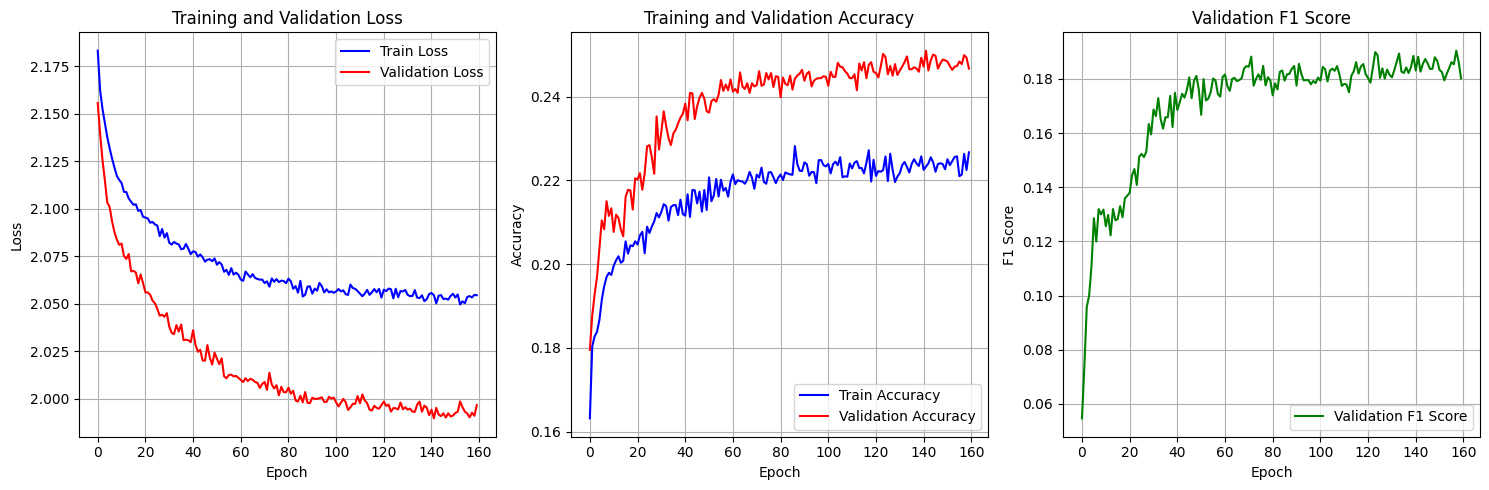


Loading best model for final evaluation...
Performing final evaluation on test set...
Starting comprehensive evaluation...


Evaluating: 100%|██████████| 33/33 [00:00<00:00, 468.07it/s]


Evaluation Metrics:
----------------------------------------
Accuracy: 0.2509
F1_score: 0.1879
F1_macro: 0.1552
F1_micro: 0.2509
Precision: 0.2043
Recall: 0.2509
Roc_auc: 0.6900
Loss: 1.9911

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

        BF_1       0.21      0.28      0.24       823
        BF_2       0.10      0.02      0.03       653
        BF_3       0.29      0.30      0.30       914
        BF_4       0.25      0.72      0.37      1234
        BF_5       0.28      0.03      0.06       610
        BF_6       0.00      0.00      0.00       551
        BF_7       0.00      0.00      0.00       568
        BF_8       0.28      0.07      0.11       506
        BF_9       0.32      0.27      0.29       650

    accuracy                           0.25      6509
   macro avg       0.19      0.19      0.16      6509
weighted avg       0.20      0.25      0.19      6509




/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

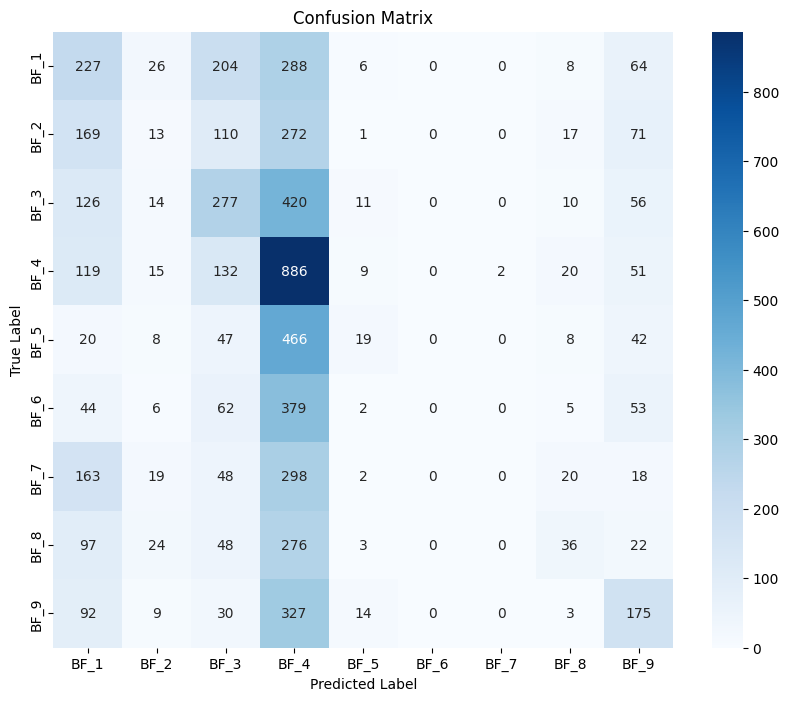

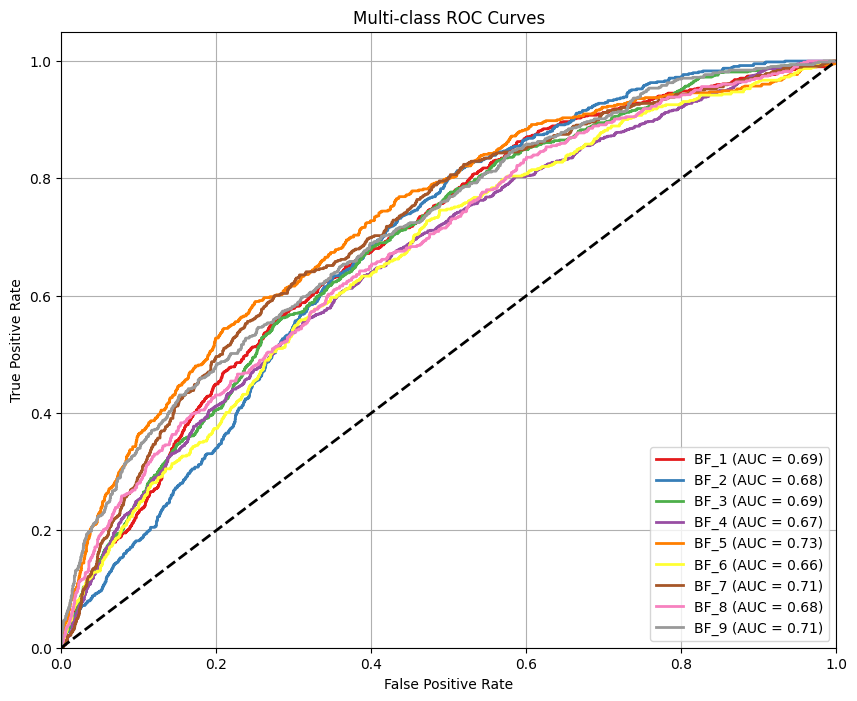

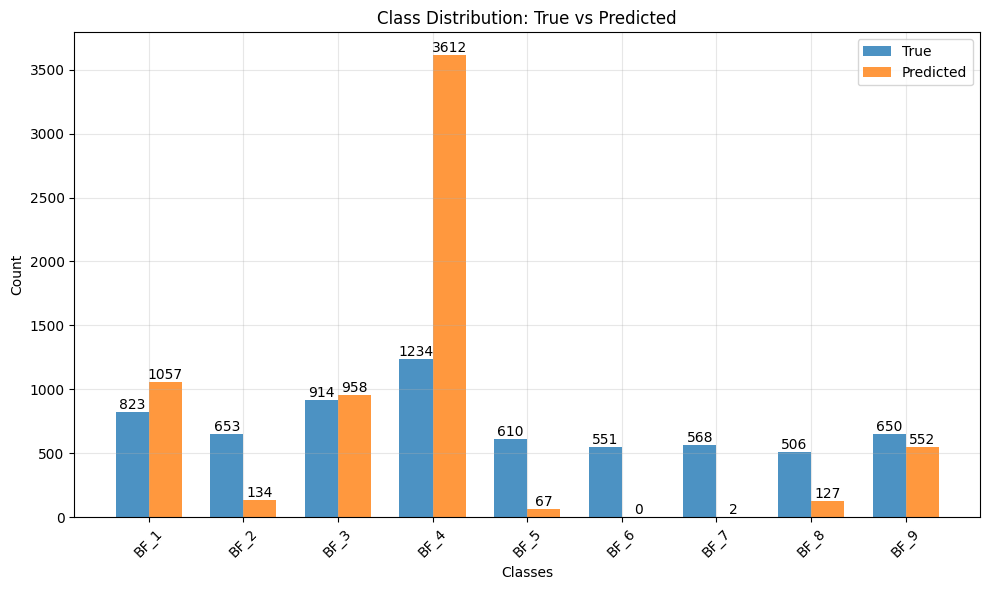


Training completed!
Results saved in: checkpoints/
Best validation accuracy: 0.2510
Final test accuracy: 0.2509
Final test F1 score: 0.1879
Final test ROC AUC: 0.6900
Training of GCN completed successfully!


In [7]:
# Comparison between the two models:
# --- 2. Train Classical GCN Model ---
print("\n--- Starting Training for Model Type: GCN ---")
args.model_type = "GCN" # Ensure model_type is set for GCN
args.num_epochs = 160
main(args, data_loader, train_loader,
     val_loader, test_loader, device,
     checkpoint_dir, eval_dir)
print("Training of GCN completed successfully!")



--- Starting Training for Model Type: QGNN ---
Model created: QGCN
Total parameters: 1,279
Starting training...
Starting training for 160 epochs...
Device: cpu
Model parameters: 1,279


Validation: 100%|██████████| 33/33 [00:02<00:00, 16.22it/s]


Epoch   1/160 | Train Loss: 2.1942 | Train Acc: 0.1568 | Val Loss: 2.1553 | Val Acc: 0.1795 | Val F1: 0.0558 | Time: 26.50s


Validation: 100%|██████████| 33/33 [00:02<00:00, 16.20it/s]


Epoch   2/160 | Train Loss: 2.1651 | Train Acc: 0.1776 | Val Loss: 2.1518 | Val Acc: 0.1798 | Val F1: 0.0565 | Time: 26.52s


Validation: 100%|██████████| 33/33 [00:02<00:00, 16.08it/s]


Epoch   3/160 | Train Loss: 2.1590 | Train Acc: 0.1804 | Val Loss: 2.1495 | Val Acc: 0.1798 | Val F1: 0.0687 | Time: 26.41s


Validation: 100%|██████████| 33/33 [00:01<00:00, 16.61it/s]


Epoch   4/160 | Train Loss: 2.1573 | Train Acc: 0.1810 | Val Loss: 2.1482 | Val Acc: 0.1810 | Val F1: 0.0682 | Time: 24.44s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.14it/s]


New best model saved at epoch 4 with validation accuracy: 0.1813
Epoch   5/160 | Train Loss: 2.1517 | Train Acc: 0.1849 | Val Loss: 2.1450 | Val Acc: 0.1813 | Val F1: 0.0689 | Time: 24.39s


Validation: 100%|██████████| 33/33 [00:02<00:00, 16.49it/s]


Epoch   6/160 | Train Loss: 2.1503 | Train Acc: 0.1848 | Val Loss: 2.1419 | Val Acc: 0.1916 | Val F1: 0.1019 | Time: 24.44s


Validation: 100%|██████████| 33/33 [00:01<00:00, 16.56it/s]


Epoch   7/160 | Train Loss: 2.1483 | Train Acc: 0.1822 | Val Loss: 2.1414 | Val Acc: 0.1882 | Val F1: 0.0884 | Time: 24.21s


Validation: 100%|██████████| 33/33 [00:01<00:00, 16.61it/s]


New best model saved at epoch 7 with validation accuracy: 0.1920
Epoch   8/160 | Train Loss: 2.1454 | Train Acc: 0.1848 | Val Loss: 2.1355 | Val Acc: 0.1920 | Val F1: 0.0944 | Time: 24.65s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.15it/s]


New best model saved at epoch 8 with validation accuracy: 0.1969
Epoch   9/160 | Train Loss: 2.1433 | Train Acc: 0.1850 | Val Loss: 2.1348 | Val Acc: 0.1969 | Val F1: 0.1096 | Time: 22.96s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.74it/s]


Epoch  10/160 | Train Loss: 2.1419 | Train Acc: 0.1863 | Val Loss: 2.1315 | Val Acc: 0.1940 | Val F1: 0.1031 | Time: 21.68s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.47it/s]


Epoch  11/160 | Train Loss: 2.1387 | Train Acc: 0.1878 | Val Loss: 2.1325 | Val Acc: 0.1913 | Val F1: 0.1034 | Time: 20.53s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.34it/s]


Epoch  12/160 | Train Loss: 2.1364 | Train Acc: 0.1887 | Val Loss: 2.1279 | Val Acc: 0.1940 | Val F1: 0.1012 | Time: 19.75s


Validation: 100%|██████████| 33/33 [00:02<00:00, 16.41it/s]


New best model saved at epoch 12 with validation accuracy: 0.1987
Epoch  13/160 | Train Loss: 2.1350 | Train Acc: 0.1886 | Val Loss: 2.1253 | Val Acc: 0.1987 | Val F1: 0.1126 | Time: 22.89s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.10it/s]


New best model saved at epoch 13 with validation accuracy: 0.2005
Epoch  14/160 | Train Loss: 2.1326 | Train Acc: 0.1903 | Val Loss: 2.1222 | Val Acc: 0.2005 | Val F1: 0.1179 | Time: 23.02s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.60it/s]


Epoch  15/160 | Train Loss: 2.1329 | Train Acc: 0.1886 | Val Loss: 2.1245 | Val Acc: 0.1967 | Val F1: 0.1170 | Time: 22.69s


Validation: 100%|██████████| 33/33 [00:02<00:00, 15.74it/s]


Epoch  16/160 | Train Loss: 2.1313 | Train Acc: 0.1892 | Val Loss: 2.1209 | Val Acc: 0.1940 | Val F1: 0.1077 | Time: 24.05s


Validation: 100%|██████████| 33/33 [00:01<00:00, 16.81it/s]


Epoch  17/160 | Train Loss: 2.1295 | Train Acc: 0.1894 | Val Loss: 2.1199 | Val Acc: 0.1966 | Val F1: 0.1081 | Time: 23.56s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.11it/s]


Epoch  18/160 | Train Loss: 2.1293 | Train Acc: 0.1906 | Val Loss: 2.1197 | Val Acc: 0.1946 | Val F1: 0.1161 | Time: 22.84s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.63it/s]


Epoch  19/160 | Train Loss: 2.1262 | Train Acc: 0.1929 | Val Loss: 2.1201 | Val Acc: 0.1987 | Val F1: 0.1206 | Time: 22.88s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.02it/s]


Epoch  20/160 | Train Loss: 2.1266 | Train Acc: 0.1891 | Val Loss: 2.1171 | Val Acc: 0.1975 | Val F1: 0.1205 | Time: 22.60s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.69it/s]


Epoch  21/160 | Train Loss: 2.1257 | Train Acc: 0.1930 | Val Loss: 2.1186 | Val Acc: 0.1934 | Val F1: 0.1110 | Time: 22.20s


Validation: 100%|██████████| 33/33 [00:01<00:00, 16.94it/s]


Epoch  22/160 | Train Loss: 2.1243 | Train Acc: 0.1904 | Val Loss: 2.1150 | Val Acc: 0.2005 | Val F1: 0.1225 | Time: 23.30s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.05it/s]


Epoch  23/160 | Train Loss: 2.1228 | Train Acc: 0.1923 | Val Loss: 2.1151 | Val Acc: 0.1989 | Val F1: 0.1178 | Time: 22.74s


Validation: 100%|██████████| 33/33 [00:02<00:00, 14.96it/s]


Epoch  24/160 | Train Loss: 2.1220 | Train Acc: 0.1919 | Val Loss: 2.1145 | Val Acc: 0.1951 | Val F1: 0.1116 | Time: 23.60s


Validation: 100%|██████████| 33/33 [00:02<00:00, 14.10it/s]


Epoch  25/160 | Train Loss: 2.1219 | Train Acc: 0.1899 | Val Loss: 2.1163 | Val Acc: 0.1958 | Val F1: 0.1147 | Time: 24.13s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.39it/s]


Epoch  26/160 | Train Loss: 2.1181 | Train Acc: 0.1908 | Val Loss: 2.1112 | Val Acc: 0.1963 | Val F1: 0.1224 | Time: 23.95s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.13it/s]


New best model saved at epoch 26 with validation accuracy: 0.2018
Epoch  27/160 | Train Loss: 2.1184 | Train Acc: 0.1939 | Val Loss: 2.1117 | Val Acc: 0.2018 | Val F1: 0.1299 | Time: 23.16s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.18it/s]


Epoch  28/160 | Train Loss: 2.1160 | Train Acc: 0.1952 | Val Loss: 2.1109 | Val Acc: 0.2001 | Val F1: 0.1244 | Time: 22.14s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.92it/s]


New best model saved at epoch 28 with validation accuracy: 0.2022
Epoch  29/160 | Train Loss: 2.1176 | Train Acc: 0.1926 | Val Loss: 2.1107 | Val Acc: 0.2022 | Val F1: 0.1284 | Time: 22.41s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.62it/s]


Epoch  30/160 | Train Loss: 2.1173 | Train Acc: 0.1938 | Val Loss: 2.1110 | Val Acc: 0.1998 | Val F1: 0.1295 | Time: 22.75s


Validation: 100%|██████████| 33/33 [00:02<00:00, 16.33it/s]


New best model saved at epoch 30 with validation accuracy: 0.2024
Epoch  31/160 | Train Loss: 2.1167 | Train Acc: 0.1928 | Val Loss: 2.1102 | Val Acc: 0.2024 | Val F1: 0.1329 | Time: 22.12s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.61it/s]


New best model saved at epoch 31 with validation accuracy: 0.2034
Epoch  32/160 | Train Loss: 2.1169 | Train Acc: 0.1941 | Val Loss: 2.1092 | Val Acc: 0.2034 | Val F1: 0.1336 | Time: 23.13s


Validation: 100%|██████████| 33/33 [00:01<00:00, 16.70it/s]


Epoch  33/160 | Train Loss: 2.1158 | Train Acc: 0.1957 | Val Loss: 2.1096 | Val Acc: 0.1981 | Val F1: 0.1271 | Time: 23.59s


Validation: 100%|██████████| 33/33 [00:01<00:00, 20.46it/s]


Epoch  34/160 | Train Loss: 2.1147 | Train Acc: 0.1947 | Val Loss: 2.1093 | Val Acc: 0.2004 | Val F1: 0.1304 | Time: 21.35s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.84it/s]


Epoch  35/160 | Train Loss: 2.1168 | Train Acc: 0.1912 | Val Loss: 2.1076 | Val Acc: 0.1995 | Val F1: 0.1294 | Time: 22.12s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.50it/s]


Epoch  36/160 | Train Loss: 2.1156 | Train Acc: 0.1933 | Val Loss: 2.1076 | Val Acc: 0.2024 | Val F1: 0.1312 | Time: 20.42s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.54it/s]


Epoch  37/160 | Train Loss: 2.1141 | Train Acc: 0.1957 | Val Loss: 2.1075 | Val Acc: 0.2012 | Val F1: 0.1305 | Time: 20.95s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.10it/s]


Epoch  38/160 | Train Loss: 2.1136 | Train Acc: 0.1935 | Val Loss: 2.1094 | Val Acc: 0.2021 | Val F1: 0.1308 | Time: 22.88s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.25it/s]


Epoch  39/160 | Train Loss: 2.1141 | Train Acc: 0.1946 | Val Loss: 2.1084 | Val Acc: 0.2016 | Val F1: 0.1321 | Time: 22.92s


Validation: 100%|██████████| 33/33 [00:02<00:00, 15.82it/s]


Epoch  40/160 | Train Loss: 2.1131 | Train Acc: 0.1928 | Val Loss: 2.1082 | Val Acc: 0.2001 | Val F1: 0.1279 | Time: 22.97s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.41it/s]


Epoch  41/160 | Train Loss: 2.1136 | Train Acc: 0.1937 | Val Loss: 2.1063 | Val Acc: 0.1996 | Val F1: 0.1313 | Time: 20.63s


Validation: 100%|██████████| 33/33 [00:01<00:00, 20.07it/s]


Epoch  42/160 | Train Loss: 2.1127 | Train Acc: 0.1960 | Val Loss: 2.1090 | Val Acc: 0.2004 | Val F1: 0.1283 | Time: 19.89s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.80it/s]


Epoch  43/160 | Train Loss: 2.1132 | Train Acc: 0.1957 | Val Loss: 2.1072 | Val Acc: 0.1993 | Val F1: 0.1258 | Time: 20.91s


Validation: 100%|██████████| 33/33 [00:01<00:00, 21.66it/s]


Epoch  44/160 | Train Loss: 2.1113 | Train Acc: 0.1957 | Val Loss: 2.1050 | Val Acc: 0.2015 | Val F1: 0.1344 | Time: 20.45s


Validation: 100%|██████████| 33/33 [00:01<00:00, 18.96it/s]


Epoch  45/160 | Train Loss: 2.1085 | Train Acc: 0.1973 | Val Loss: 2.1060 | Val Acc: 0.2016 | Val F1: 0.1355 | Time: 19.51s


Validation: 100%|██████████| 33/33 [00:01<00:00, 20.53it/s]


Epoch  46/160 | Train Loss: 2.1107 | Train Acc: 0.1970 | Val Loss: 2.1045 | Val Acc: 0.2002 | Val F1: 0.1346 | Time: 21.31s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.22it/s]


New best model saved at epoch 46 with validation accuracy: 0.2054
Epoch  47/160 | Train Loss: 2.1097 | Train Acc: 0.1950 | Val Loss: 2.1048 | Val Acc: 0.2054 | Val F1: 0.1356 | Time: 19.84s


Validation: 100%|██████████| 33/33 [00:01<00:00, 16.77it/s]


Epoch  48/160 | Train Loss: 2.1105 | Train Acc: 0.1953 | Val Loss: 2.1041 | Val Acc: 0.2051 | Val F1: 0.1369 | Time: 20.80s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.26it/s]


Epoch  49/160 | Train Loss: 2.1096 | Train Acc: 0.1963 | Val Loss: 2.1043 | Val Acc: 0.1983 | Val F1: 0.1302 | Time: 19.94s


Validation: 100%|██████████| 33/33 [00:01<00:00, 20.12it/s]


Epoch  50/160 | Train Loss: 2.1105 | Train Acc: 0.1941 | Val Loss: 2.1042 | Val Acc: 0.1996 | Val F1: 0.1314 | Time: 19.58s


Validation: 100%|██████████| 33/33 [00:02<00:00, 15.18it/s]


Epoch  51/160 | Train Loss: 2.1093 | Train Acc: 0.1987 | Val Loss: 2.1046 | Val Acc: 0.2013 | Val F1: 0.1303 | Time: 21.52s


Validation: 100%|██████████| 33/33 [00:01<00:00, 16.89it/s]


Epoch  52/160 | Train Loss: 2.1085 | Train Acc: 0.1950 | Val Loss: 2.1031 | Val Acc: 0.2019 | Val F1: 0.1342 | Time: 21.42s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.24it/s]


Epoch  53/160 | Train Loss: 2.1086 | Train Acc: 0.1974 | Val Loss: 2.1029 | Val Acc: 0.1995 | Val F1: 0.1339 | Time: 21.61s


Validation: 100%|██████████| 33/33 [00:01<00:00, 21.20it/s]


Epoch  54/160 | Train Loss: 2.1084 | Train Acc: 0.1966 | Val Loss: 2.1031 | Val Acc: 0.2018 | Val F1: 0.1331 | Time: 19.82s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.39it/s]


Epoch  55/160 | Train Loss: 2.1085 | Train Acc: 0.1963 | Val Loss: 2.1032 | Val Acc: 0.2007 | Val F1: 0.1360 | Time: 20.17s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.08it/s]


Epoch  56/160 | Train Loss: 2.1093 | Train Acc: 0.1958 | Val Loss: 2.1033 | Val Acc: 0.1995 | Val F1: 0.1296 | Time: 21.69s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.45it/s]


Epoch  57/160 | Train Loss: 2.1072 | Train Acc: 0.1969 | Val Loss: 2.1026 | Val Acc: 0.2018 | Val F1: 0.1365 | Time: 20.64s


Validation: 100%|██████████| 33/33 [00:01<00:00, 20.05it/s]


Epoch  58/160 | Train Loss: 2.1084 | Train Acc: 0.1954 | Val Loss: 2.1018 | Val Acc: 0.2002 | Val F1: 0.1346 | Time: 20.58s


Validation: 100%|██████████| 33/33 [00:01<00:00, 16.95it/s]


Epoch  59/160 | Train Loss: 2.1084 | Train Acc: 0.1974 | Val Loss: 2.1019 | Val Acc: 0.2028 | Val F1: 0.1365 | Time: 21.63s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.83it/s]


Epoch  60/160 | Train Loss: 2.1082 | Train Acc: 0.1980 | Val Loss: 2.1016 | Val Acc: 0.2027 | Val F1: 0.1359 | Time: 19.92s


Validation: 100%|██████████| 33/33 [00:02<00:00, 15.60it/s]


Epoch  61/160 | Train Loss: 2.1078 | Train Acc: 0.1989 | Val Loss: 2.1023 | Val Acc: 0.2030 | Val F1: 0.1375 | Time: 22.48s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.80it/s]


Epoch  62/160 | Train Loss: 2.1064 | Train Acc: 0.1974 | Val Loss: 2.1018 | Val Acc: 0.2019 | Val F1: 0.1365 | Time: 21.83s


Validation: 100%|██████████| 33/33 [00:01<00:00, 20.21it/s]


Epoch  63/160 | Train Loss: 2.1076 | Train Acc: 0.1971 | Val Loss: 2.1020 | Val Acc: 0.2041 | Val F1: 0.1386 | Time: 20.21s


Validation: 100%|██████████| 33/33 [00:01<00:00, 21.25it/s]


Epoch  64/160 | Train Loss: 2.1078 | Train Acc: 0.1960 | Val Loss: 2.1018 | Val Acc: 0.2047 | Val F1: 0.1393 | Time: 19.43s


Validation: 100%|██████████| 33/33 [00:01<00:00, 22.40it/s]


Epoch  65/160 | Train Loss: 2.1080 | Train Acc: 0.1976 | Val Loss: 2.1022 | Val Acc: 0.2022 | Val F1: 0.1361 | Time: 18.87s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.62it/s]


Epoch  66/160 | Train Loss: 2.1083 | Train Acc: 0.1988 | Val Loss: 2.1020 | Val Acc: 0.2028 | Val F1: 0.1377 | Time: 18.76s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.45it/s]


Epoch  67/160 | Train Loss: 2.1066 | Train Acc: 0.1970 | Val Loss: 2.1013 | Val Acc: 0.2034 | Val F1: 0.1378 | Time: 20.45s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.47it/s]


Epoch  68/160 | Train Loss: 2.1064 | Train Acc: 0.1971 | Val Loss: 2.1021 | Val Acc: 0.2027 | Val F1: 0.1370 | Time: 21.04s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.06it/s]


Epoch  69/160 | Train Loss: 2.1066 | Train Acc: 0.1987 | Val Loss: 2.1017 | Val Acc: 0.2037 | Val F1: 0.1404 | Time: 21.34s


Validation: 100%|██████████| 33/33 [00:01<00:00, 17.45it/s]


Epoch  70/160 | Train Loss: 2.1059 | Train Acc: 0.1970 | Val Loss: 2.1009 | Val Acc: 0.2037 | Val F1: 0.1400 | Time: 19.70s


Validation: 100%|██████████| 33/33 [00:01<00:00, 20.67it/s]


Epoch  71/160 | Train Loss: 2.1052 | Train Acc: 0.1974 | Val Loss: 2.1012 | Val Acc: 0.2051 | Val F1: 0.1405 | Time: 21.05s


Validation: 100%|██████████| 33/33 [00:01<00:00, 19.53it/s]


Epoch  72/160 | Train Loss: 2.1065 | Train Acc: 0.1980 | Val Loss: 2.1009 | Val Acc: 0.2044 | Val F1: 0.1400 | Time: 20.19s


Validation: 100%|██████████| 33/33 [00:02<00:00, 15.78it/s]


Epoch  73/160 | Train Loss: 2.1070 | Train Acc: 0.1969 | Val Loss: 2.1010 | Val Acc: 0.2036 | Val F1: 0.1396 | Time: 21.08s
Early stopping at epoch 73

Training completed!
Best validation accuracy: 0.2054 at epoch 47


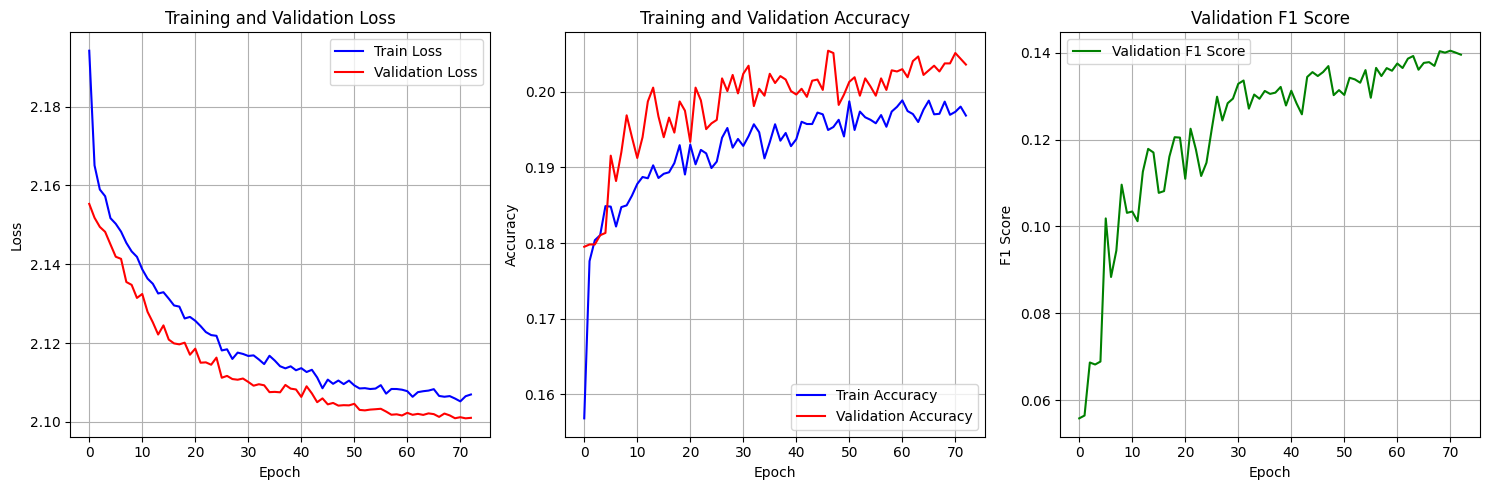


Loading best model for final evaluation...
Performing final evaluation on test set...
Starting comprehensive evaluation...


Evaluating: 100%|██████████| 33/33 [00:01<00:00, 21.57it/s]
/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter


Evaluation Metrics:
----------------------------------------
Accuracy: 0.2036
F1_score: 0.1322
F1_macro: 0.1067
F1_micro: 0.2036
Precision: 0.1557
Recall: 0.2036
Roc_auc: 0.5997
Loss: 2.1053

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

        BF_1       0.21      0.13      0.16       823
        BF_2       0.11      0.02      0.03       653
        BF_3       0.23      0.11      0.15       914
        BF_4       0.21      0.80      0.33      1234
        BF_5       0.22      0.11      0.14       610
        BF_6       0.00      0.00      0.00       551
        BF_7       0.00      0.00      0.00       568
        BF_8       0.17      0.08      0.10       506
        BF_9       0.13      0.03      0.05       650

    accuracy                           0.20      6509
   macro avg       0.14      0.14      0.11      6509
weighted avg       0.16      0.20      0.13      6509



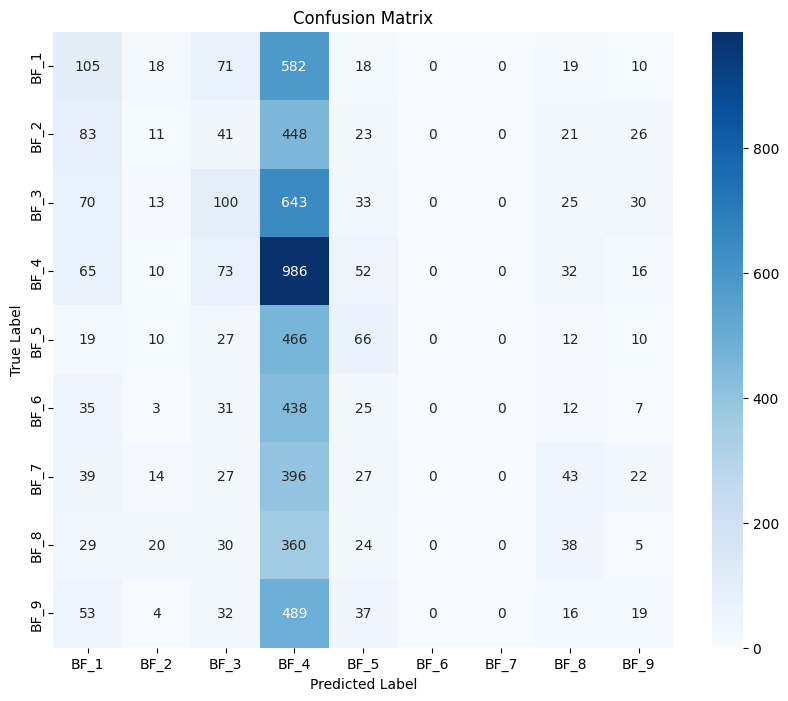

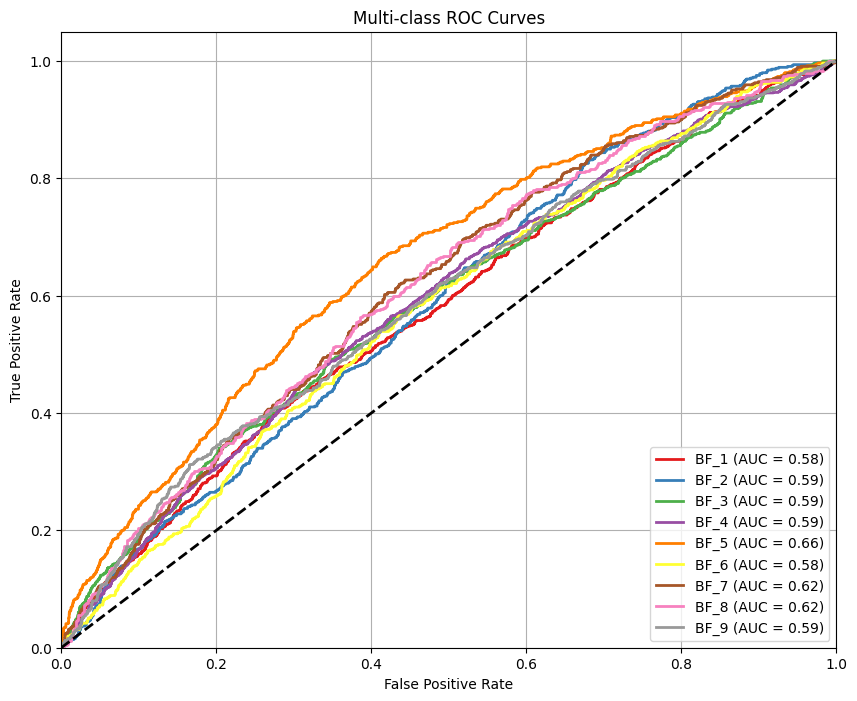

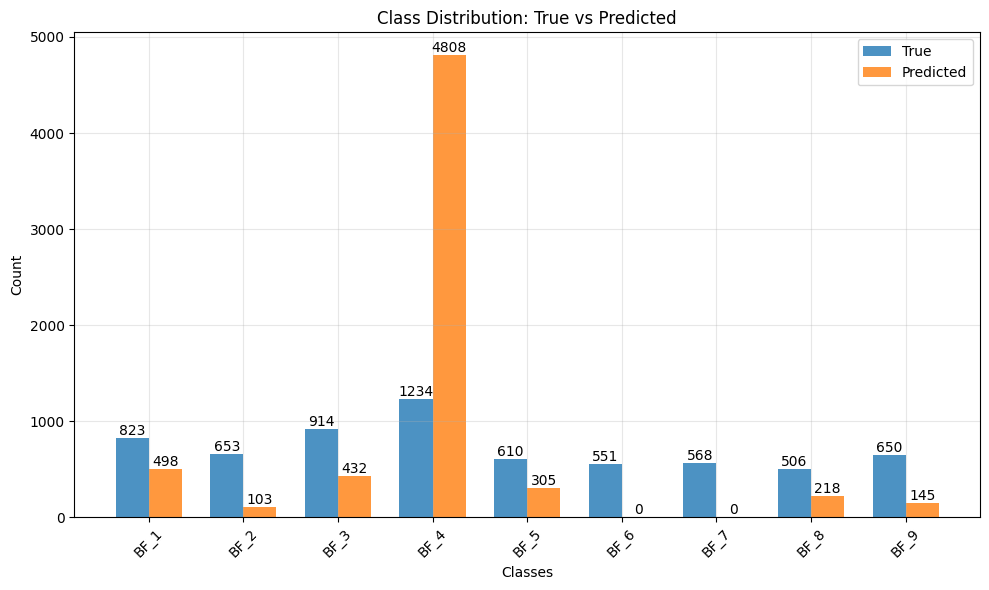


Training completed!
Results saved in: checkpoints/
Best validation accuracy: 0.2054
Final test accuracy: 0.2036
Final test F1 score: 0.1322
Final test ROC AUC: 0.5997
Training of QGCN completed successfully!

Both GCN and QGCN training pipelines have completed. Check your specified 'save_dir' and 'eval_dir' for results.


In [6]:
# --- 3. Train Quantum GNN Model (QGNN) ---
print("\n--- Starting Training for Model Type: QGNN ---")
args.model_type = "QGCN" # Ensure model_type is set for QGNN
args.num_epochs = 160
args.shots = None  # Default shots for quantum training

if not args.api_key:
     raise ValueError("QBRAID_API_KEY environment variable is not set. Please set it in your environment to run QGNN.")

main(args, data_loader, train_loader,
     val_loader, test_loader, device,
     checkpoint_dir, eval_dir)

print("Training of QGCN completed successfully!")

# --- 5. Conclusion ---
print("\nBoth GCN and QGCN training pipelines have completed. Check your specified 'save_dir' and 'eval_dir' for results.")
